In [1]:
# Klasterizuojami ML anotuoti pūpsniai neskaidant į grupes
# su ML anotacijomis N, S, V, U. 
# 
# # Skriptas EKG įrašo pūpsnių klasterizacijai panaudojant VU FDA požymius
# Šis variantas pritaikytas įrašams, kuriems rpeaks surandami su Neurokitu,
# o anotacijos yra gautos su ML.anotuotams įrašams. Yra ir kitas variantas
# (zive_clustering_of_annotated_records.ipynb), pritaikytas darbui su rpeaks
# ir anotacijomis, atsisiųtomis iš duomneų bazės.   

# Planas:
# Nuskaitome EKG įrašą
# Surandame su Neurokit2 R pikus
# Apskaičiuojame visiems pūpsniams požymius ir suformuojame požymių masyvą
# Surandame visiems R pikams ML anotacijas
# Atliekame klasterizaciją
# Atvaizduojame klasterius grafiškai

import tensorflow as tf
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
import time
import sys, os, json
from pathlib import Path
import pickle
import sklearn
import neurokit2 as nk
from zive_clustering import get_sequences_min_max, show_beats, show_beats_in_same_plot


my_os=sys.platform
print("OS in my system : ",my_os)

if my_os != 'linux':
    OS = 'Windows'
else:  
    OS = 'Ubuntu'

# Į sys.path įtraukiamas aukščiau esantis aplankas, reikalingas modulių importavimui
# https://www.geeksforgeeks.org/get-parent-of-current-directory-using-python/ panaudojau šitą
path = os.getcwd() # Current Directory
parent = os.path.dirname(path) # parent directory
sys.path.insert(1, parent)

from zive_util_vu import runtime
from zive_cnn_fda_vu_v3_micro import get_beat_features_set_fda_vu_v1_micro
from zive_util_vu import create_dir, get_rec_file_name, get_recId
from zive_util_vu import get_seq_start_end, read_rec, read_rec_attrib, split_SubjCode
from zive_cnn_fda_vu_v3_micro import read_RR_arr_from_signal, read_seq_from_signal

np.set_printoptions(threshold=sys.maxsize)
print('tf version:', tf.__version__)
print('sklearn version:', sklearn.__version__)


OS in my system :  win32
tf version: 2.8.2
sklearn version: 0.24.1


In [2]:
# Pagrindinis skriptas

print("Skriptas bandymams klasterizuoti EKG įrašo pūpsnius su ML anotacijomis neskaidant į anotacijų grupes")
print('Naudojami VU FDA požymiai, scaler ir modelio parametrai nuskaitomi iš modelio CNN VU aplanko')


# //////////////// NURODOMI DUOMENŲ PARAMETRAI /////////////////////////////////////////////////////

# Bendras duomenų aplankas, kuriame patalpintas subfolderis name_db

if OS == 'Windows':
    Duomenu_aplankas = 'D:\\DI'   # variantas: Windows
    # Duomenu_aplankas = 'F:\DI\Data\MIT&ZIVE\VU'   # variantas: Herkulis
else:
    Duomenu_aplankas = '/home/kesju/DI'   # arba variantas: UBUNTU, be Docker

# jei variantas Docker pasirenkame:
# Duomenu_aplankas = '/Data/MIT&ZIVE'

# Vietinės talpyklos aplankas ir pūpsnių atributų failas
db_folder = 'DUOM_2022_RUDUO_2'

# Failai pūpsnių klasių formavimui
selected_beats = {'N':0, 'S':1, 'V':2}
all_beats =  {'N':0, 'S':1, 'V':2, 'U':3}  

# Diskretizavimo dažnis:
fs = 200

#  Nuoroda į aplanką su duomenų rinkiniu
db_path = Path(Duomenu_aplankas, db_folder)

# Nuoroda į aplanką su EKG įrašais (.npy) ir anotacijomis (.json)
rec_dir = Path(db_path, 'records_npy')

# Nuoroda į modelio aplanką
# model_dir = Path(Duomenu_aplankas, 'DNN', 'best_models', 'all_ft')
model_dir = 'model_cnn_fda_vu_v1'

# Išvedame parametrus
print("\nBendras duomenų aplankas: ", Duomenu_aplankas)
print("Zive duomenų aplankas: ", db_folder)
print("Aplankas su originaliais EKG įrašais ir anotacijomis (.json) ", rec_dir)
print("Diskretizavimo dažnis: ", fs)
print('Klasifikavimo schema:', selected_beats)
print('Klasių skaičius:', len(selected_beats))
print('Visos galimos anotacijos:', list(all_beats.keys()))
print("Scaler ir modelio parametrai nuskaitomi iš aplanko: ", model_dir)
# print("\n")


# mark1

# NURODOME PACIENTŲ SĄRAŠĄ. GALIMI ĮVAIRŪS VARIANTAI
# SubjCode = 105411   #Testavimui
# SubjCode = 101322   #Testavimui
# 22    1013   22	6144cd8bbd0cc52ca32753a4	1631032.393	862	0	49	0	849	6	39	17	2,90 - daug ML U
# SubjCode = 100817
# 62	1008	17	613f58593d08d461accdcd3f	1630810.723	665	0	7	3	662	0	3	10	0,30 - yra 3 rankinės U
# SubjCode = 106719
# 1067	19	61b32738cf0f345ce2cb1ce8	1638193.61	734	2	16	0	742	1	7	2
# SubjCode = 10703
# 1070	3	61b32860cf0f34eee2cb207e	1638807.647	543	0	4	0	541	0	1	5
SubjCode = 101322   #Testavimui
# 22    1013   22	6144cd8bbd0cc52ca32753a4	1631032.393	862	0	49	0	849	6	39	17	2,90 - daug ML U


# Užduodame klasterių skaičių
uzd_clusters=20

# //////////////// PASIRUOŠIMAS ////////////////////////////////////////////////////////////////////

pd.set_option("display.max_rows", 6000)
pd.set_option("display.max_columns",200)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings("ignore")

# Klasių simbolinių vardų sąrašas ir klasių skaičius
class_names = list(selected_beats.keys()) 
n_classes = len(selected_beats)
# print(class_names)

# Naudojamų požymių sąrašas 
all_features = ['seq_size','RR_l_0', 'RR_r_0', 'RR_r/RR_l','wl_side','wr_side',
                'signal_mean', 'signal_std', 'P_val', 'Q_val', 'R_val', 'S_val', 'T_val',
                'P_pos', 'Q_pos', 'R_pos', 'S_pos', 'T_pos', 'QRS', 'PR', 'ST', 'QT', '0', '1', '2',
                '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18',
                '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32',
                '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46',
                '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
                '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74',
                '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88',
                '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102',
                '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114',
                '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126',
                '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138',
                '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150',
                '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162',
                '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174',
                '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186',
                '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198',
                '199']

# nuskaitome modelio parametrus
model_path = Path(parent, model_dir, 'best_model_final_2.h5')
model = tf.keras.models.load_model(model_path)

 # Nuskaitome scaler objectą
path_scaler = Path(parent, model_dir, 'scaler.pkl')  
scaler = pickle.load(open(path_scaler,'rb'))


# //////////////// NUSKAITOMAS ĮRAŠAS /////////////////////////////////////////////////////
# šis variantas pritaikytas įrašams, kuriems rpeaks surandami su Neurokitu,
# o anotacijos yra gautos su ML.anotuotams įrašams.

print("Klasterizuojamas įrašas:", SubjCode)
print("Užduota klasterių:", uzd_clusters)

start_time = time.time()

# Nuskaitome EKG įrašą (npy formatu)
file_path = Path(rec_dir, str(SubjCode) + '.npy')
sign_raw = np.load(file_path)
# sign_raw = read_rec(rec_dir, SubjCode)
signal_length = sign_raw.shape[0]
signal = sign_raw

# Surandame ir išvedame įrašo atributus
userNr, recNr = split_SubjCode(SubjCode)
userId, recId, file_name = get_recId(rec_dir, userNr, recNr)
print(f"\nSubjCode: {SubjCode} userNr: {userNr:>2} file_name: {file_name:>2} userId: {userId} recId: {recId} signal_length: {signal_length}")

# Nustatome R pikų vietas
_, rpeaks = nk.ecg_peaks(signal, sampling_rate=200, correct_artifacts=False)
atr_sample = rpeaks['ECG_R_Peaks']
# print(type(atr_sample))
# print("Neurokit:",atr_sample[:50])


idx_lst = list(range(1, len(atr_sample)-1))  # pastaba: idx_lst sąrašas nuo 1 iki atr_sample-2

# Formuojame iš pūpsnių požymių masyvą: data_frame yra tik tos eilutės,
# kurių indeksai nepapuolė į omitted (atitinka automatines anotacijas 'U')
df_attr_features_be_U, omitted = get_beat_features_set_fda_vu_v1_micro(signal, atr_sample, idx_lst)

data_frame = df_attr_features_be_U.set_index('idx')
df_attr_features_be_U.columns = df_attr_features_be_U.columns.astype(str)

# paruošiame požymių masyvą klasifikatoriui
test_x = df_attr_features_be_U[all_features]
x_test = scaler.transform(test_x)
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Pūpsnių klasių atpažinimas
predictions = model.predict(x_test)
atr_labels_be_U = np.argmax(predictions, axis=1)

# Parengiame R pikų ir ML anotacijų masyvus taip, kad juose nebūtų elementų iš omitted,
# taip pat atmetame reikšmes su indeksu 1 ir len(atr_sample)-1)

# Atmetame reikšmes su indeksu 1 ir len(atr_sample)-1)
print("len(test_x):", len(test_x))
atr_sample = atr_sample[idx_lst]
print("atmetus 1 ir paskutini:",len(atr_sample))
# print("atmetus 1 ir paskutini:", atr_sample[:50])

# Suformuojame atr_sample_be_U
atr_sample_be_U = atr_sample
idxs_su_U = []
if (not omitted.empty):
    idxs_su_U = list(omitted['idx'])
    print("idxs_su_U:",idxs_su_U)
    atr_sample_be_U = np.asarray([atr_sample[item] for item in range(len(atr_sample)) if (item not in idxs_su_U)])
print("atmetus su 'U':",len(atr_sample_be_U))
# print("atr_sample_be_U:", atr_sample_be_U[:50])

# Suformuojame atr_symbol_be_U
inv_all_beats = {v: k for k, v in all_beats.items()}
atr_symbol_be_U = np.array([inv_all_beats[sample] for sample in atr_labels_be_U])
# print("atr_symbol_be_U:",atr_symbol_be_U[:50])

# Pūpsnių statistika
(unique, counts) = np.unique(atr_symbol_be_U, return_counts=True)
total = counts.sum()
print("class labels: ", unique, counts, total)

# Pridedame atributus atr_sample_be_U, atr_symbol_be_U prie požymių datafreimo,
# skirto klasterizacijai
df_attr_features_be_U['atr_sample'] = atr_sample_be_U
df_attr_features_be_U['atr_symbol'] = atr_symbol_be_U

# # Suformuojame masyvą su `U` df_attr_su_U, kuris bus naudojamas kaip atskiras klasteris
# # df_attr_su_U = pd.DataFrame(columns=['atr_sample', 'atr_symbol',  'cluster'])
df_attr_su_U = pd.DataFrame()
if (idxs_su_U):
    attr_su_U = []
    for item in idxs_su_U:
        dict_tmp = {
            'atr_sample': atr_sample[item],
            'atr_symbol': 'U',
            'cluster': 99
        }
        attr_su_U.append(dict_tmp)
    df_attr_su_U = pd.DataFrame(attr_su_U)
print("\nKlasteris su U: df_attr_su_U")
print(df_attr_su_U)

end_time = time.time()
print('\npožymiai:')
runtime(end_time-start_time)

# 662	0	3	10
# SubjCode = 106719
# 1067	19	61b32738cf0f345ce2cb1ce8	1638193.61	734	2	16	0	742	1	7	2
# SubjCode = 10703
# 1070	3	61b32860cf0f34eee2cb207e	1638807.647	543	0	4	0	541	0	1	5


Skriptas bandymams klasterizuoti EKG įrašo pūpsnius su ML anotacijomis neskaidant į anotacijų grupes
Naudojami VU FDA požymiai, scaler ir modelio parametrai nuskaitomi iš modelio CNN VU aplanko

Bendras duomenų aplankas:  D:\DI
Zive duomenų aplankas:  DUOM_2022_RUDUO_2
Aplankas su originaliais EKG įrašais ir anotacijomis (.json)  D:\DI\DUOM_2022_RUDUO_2\records_npy
Diskretizavimo dažnis:  200
Klasifikavimo schema: {'N': 0, 'S': 1, 'V': 2}
Klasių skaičius: 3
Visos galimos anotacijos: ['N', 'S', 'V', 'U']
Scaler ir modelio parametrai nuskaitomi iš aplanko:  model_cnn_fda_vu_v1
Klasterizuojamas įrašas: 101322
Užduota klasterių: 20

SubjCode: 101322 userNr: 1013 file_name: 1631032.393 userId: 6144c4fbbd0cc552e427535f recId: 6144cd8bbd0cc52ca32753a4 signal_length: 127999
len(test_x): 894
atmetus 1 ir paskutini: 909
idxs_su_U: [345, 347, 348, 351, 353, 399, 546, 550, 624, 626, 629, 630, 636, 649, 776]
atmetus su 'U': 894
class labels:  ['N' 'S' 'V'] [849   6  39] 894

Klasteris su U: df_attr

In [3]:
# //////////////// KLASTERIZACIJA //////////////////////////////////////////////////////
# https://machinelearningmastery.com/clustering-algorithms-with-python/
# K_MEANS

from sklearn.cluster import KMeans

start_time = time.time()

# Paliekame tik užduotus požymius ir normalizuojame
df_tmp = df_attr_features_be_U[all_features]
# print(data_frame_init.head())
# Duomenis normalizuojame
X = scaler.transform(df_tmp)

# define the model
model = KMeans(n_clusters=20)

# fit the model
model.fit(X)

# assign a cluster to each example
yhat = model.predict(X)
# print(type(yhat), yhat.shape)

# retrieve unique clusters
clusters = np.unique(yhat)
# print(clusters)

# Testavimui
# for cluster in clusters:
#     # get row indexes for samples with this cluster
    # row_ix = np.where(yhat == cluster)
    # print(type(row_ix))
    # print(row_ix[0])
    # row_lst = row_ix[0]
    # print(row_lst[:20])

# Paliekame masyvus tik su atributais, be požymių, požymių stulpelius panaikiname
df_attr_be_U = df_attr_features_be_U.drop(all_features, axis=1, inplace=False)

# Papildome atributus klasterių numeriais 
df_attr_be_U['cluster'] = list(yhat)
# print("\nKlasteris be U: df_attr_be_U")
# print(df_attr_be_U.head(10))

end_time = time.time()
print('\nklasterizacija:')
runtime(end_time-start_time)



klasterizacija:
Runtime: 00:00:00



SubjCode: 101322 userNr: 1013 file_name: 1631032.393 userId: 6144c4fbbd0cc552e427535f recId: 6144cd8bbd0cc52ca32753a4 signal_length: 127999

Bendra statistika:
Klasės be 'U':  ['N' 'S' 'V'] [849   6  39] 894
Klasės su 'U' (be 1-o ir paskutinio pūpsnio): ['U'] [15] 15

item:      0   cluster:     18   statistika: ['N' 'S'] [236   1] 237
item:      1   cluster:      2   statistika: ['N' 'S'] [154   3] 157
item:      2   cluster:      0   statistika: ['N' 'S'] [124   2] 126
item:      3   cluster:     12   statistika: ['N'] [118] 118
item:      4   cluster:      6   statistika: ['N'] [88] 88
item:      5   cluster:     14   statistika: ['N' 'V'] [38  1] 39
item:      6   cluster:      9   statistika: ['N' 'V'] [16 15] 31
item:      7   cluster:     16   statistika: ['N'] [29] 29
item:      8   cluster:     13   statistika: ['N' 'V'] [ 3 19] 22
item:      9   cluster:      7   statistika: ['N' 'V'] [17  2] 19
item:     10   cluster:      5   statistika: ['N'] [10] 10
item:     11   cluste

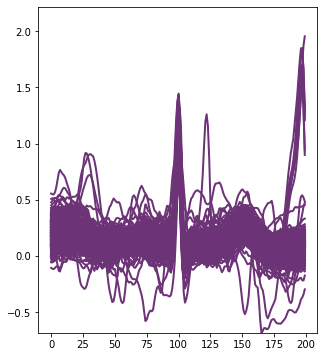

{'seq_nr': 0, 'rpeak': 4507, 'symbol': 'N'}


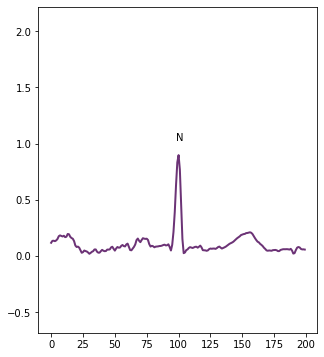

{'seq_nr': 1, 'rpeak': 4649, 'symbol': 'N'}


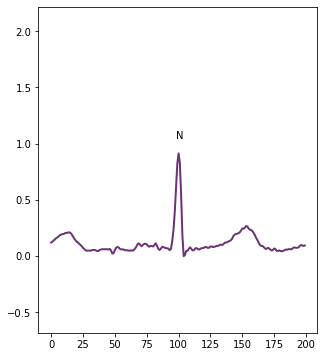

{'seq_nr': 2, 'rpeak': 5471, 'symbol': 'N'}


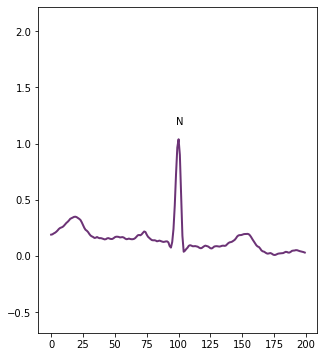


item: 1 cluster: 2 size: 157
statistika klasteryje:  ['N' 'S'] [154   3] 157
S: (idx, rpeak) {0: 112604}


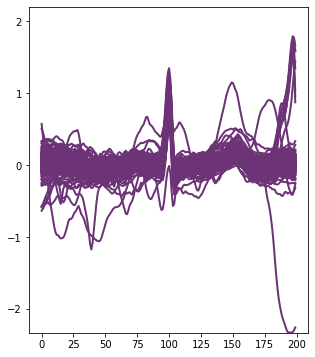

{'seq_nr': 0, 'rpeak': 4222, 'symbol': 'N'}


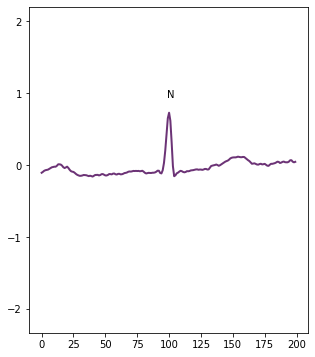

{'seq_nr': 1, 'rpeak': 4365, 'symbol': 'N'}


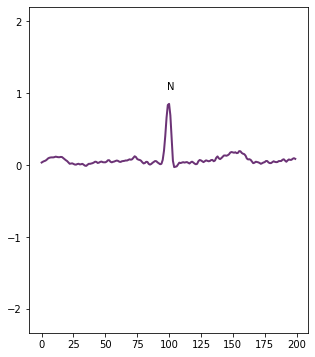

{'seq_nr': 2, 'rpeak': 5608, 'symbol': 'N'}


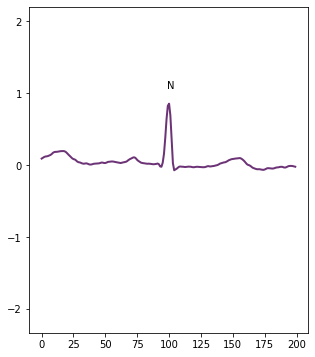


item: 2 cluster: 0 size: 126
statistika klasteryje:  ['N' 'S'] [124   2] 126
S: (idx, rpeak) {0: 70813}


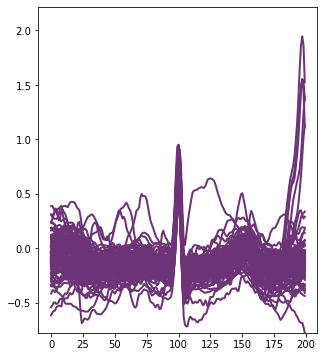

{'seq_nr': 0, 'rpeak': 2922, 'symbol': 'N'}


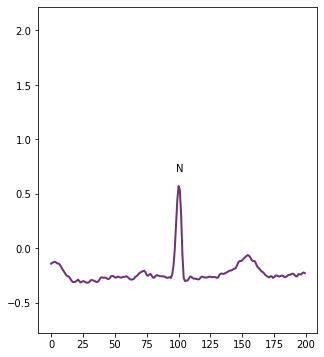

{'seq_nr': 1, 'rpeak': 3069, 'symbol': 'N'}


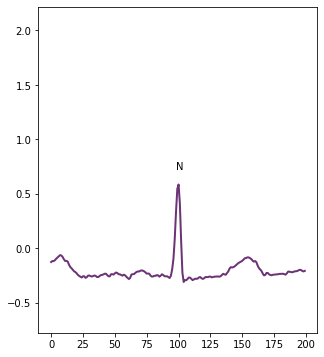

{'seq_nr': 2, 'rpeak': 3212, 'symbol': 'N'}


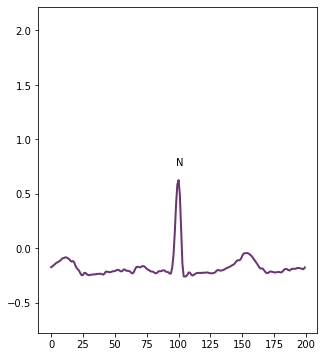


item: 3 cluster: 12 size: 118
statistika klasteryje:  ['N'] [118] 118


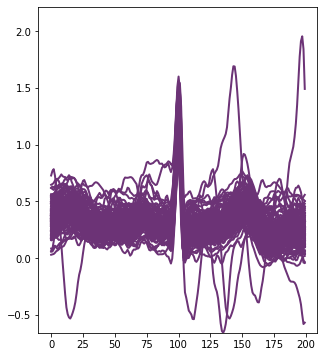

{'seq_nr': 0, 'rpeak': 4924, 'symbol': 'N'}


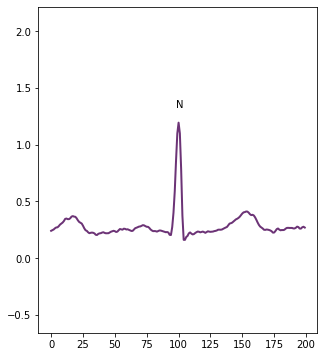

{'seq_nr': 1, 'rpeak': 6336, 'symbol': 'N'}


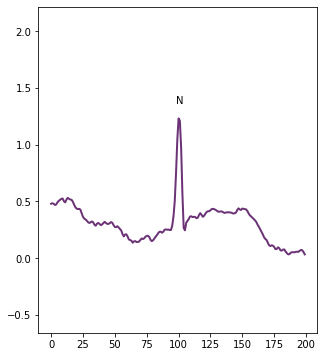

{'seq_nr': 2, 'rpeak': 8482, 'symbol': 'N'}


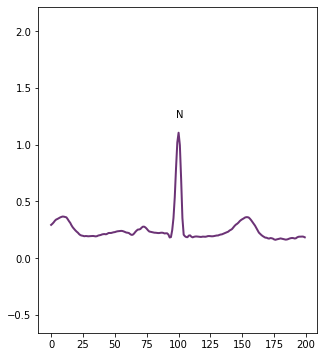


item: 4 cluster: 6 size: 88
statistika klasteryje:  ['N'] [88] 88


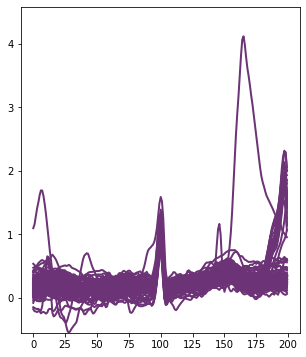

{'seq_nr': 0, 'rpeak': 4787, 'symbol': 'N'}


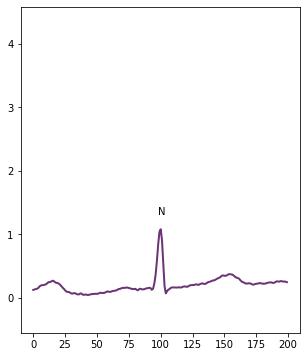

{'seq_nr': 1, 'rpeak': 5060, 'symbol': 'N'}


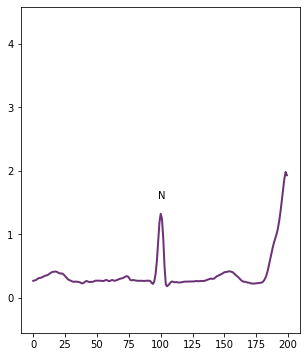

{'seq_nr': 2, 'rpeak': 5335, 'symbol': 'N'}


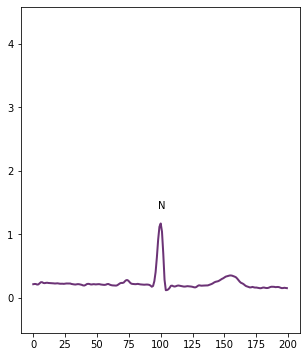


item: 5 cluster: 14 size: 39
statistika klasteryje:  ['N' 'V'] [38  1] 39
V: (idx, rpeak) {0: 61667}


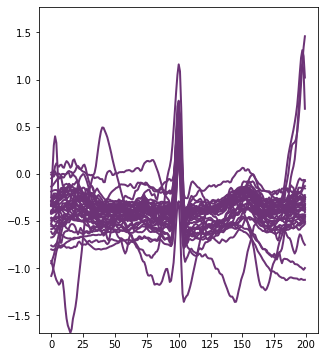

{'seq_nr': 0, 'rpeak': 2466, 'symbol': 'N'}


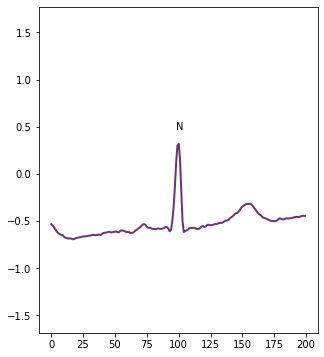

{'seq_nr': 1, 'rpeak': 2618, 'symbol': 'N'}


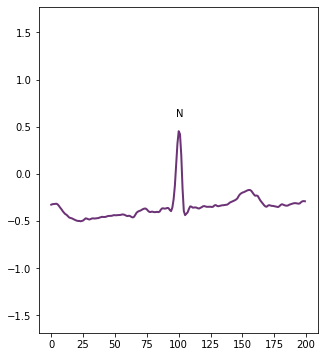

{'seq_nr': 2, 'rpeak': 2770, 'symbol': 'N'}


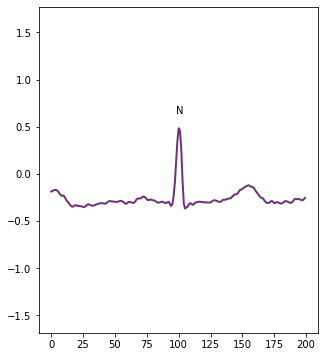


item: 6 cluster: 9 size: 31
statistika klasteryje:  ['N' 'V'] [16 15] 31
V: (idx, rpeak) {0: 124997}


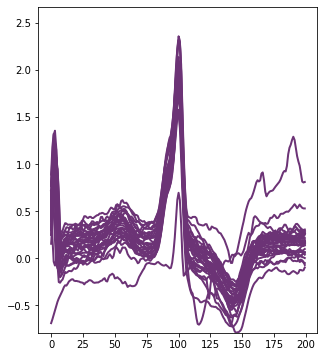

{'seq_nr': 0, 'rpeak': 5158, 'symbol': 'V'}


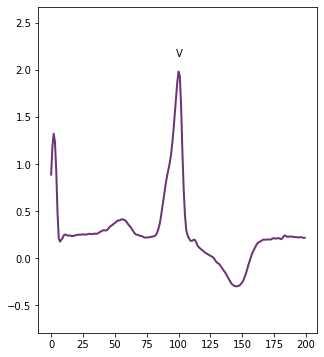

{'seq_nr': 1, 'rpeak': 9703, 'symbol': 'V'}


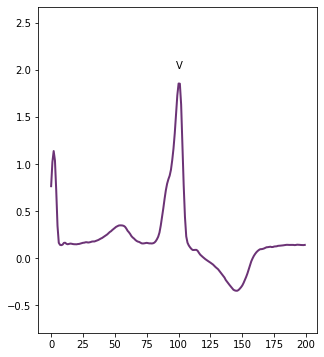

{'seq_nr': 2, 'rpeak': 10256, 'symbol': 'N'}


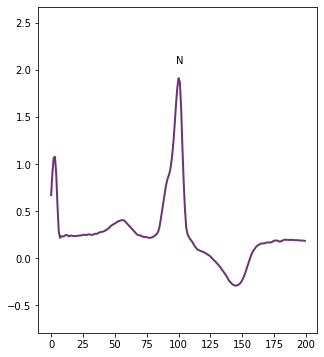


item: 7 cluster: 16 size: 29
statistika klasteryje:  ['N'] [29] 29


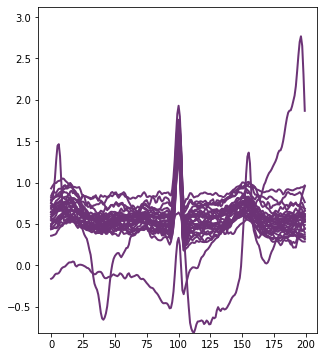

{'seq_nr': 0, 'rpeak': 46762, 'symbol': 'N'}


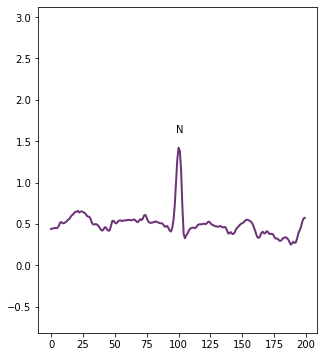

{'seq_nr': 1, 'rpeak': 51708, 'symbol': 'N'}


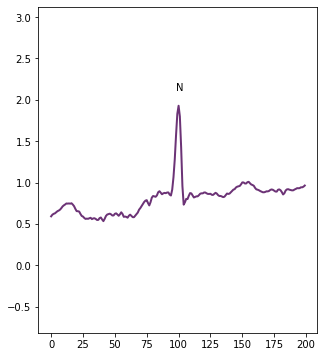

{'seq_nr': 2, 'rpeak': 53317, 'symbol': 'N'}


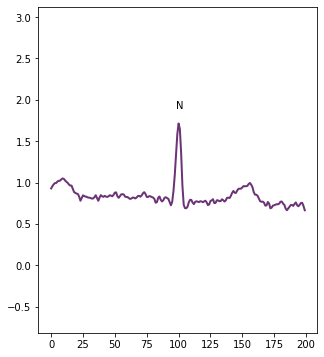


item: 8 cluster: 13 size: 22
statistika klasteryje:  ['N' 'V'] [ 3 19] 22
V: (idx, rpeak) {0: 125505}


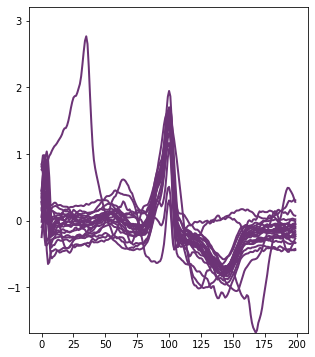

{'seq_nr': 0, 'rpeak': 28239, 'symbol': 'V'}


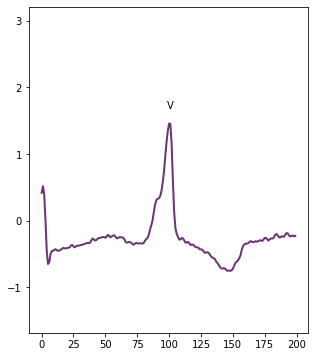

{'seq_nr': 1, 'rpeak': 46207, 'symbol': 'V'}


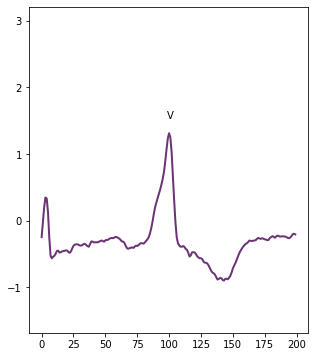

{'seq_nr': 2, 'rpeak': 60774, 'symbol': 'V'}


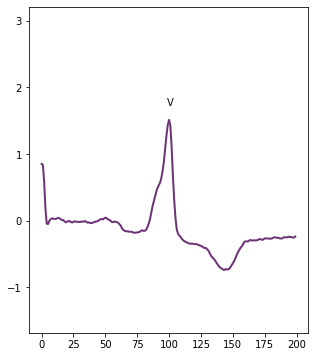


item: 9 cluster: 7 size: 19
statistika klasteryje:  ['N' 'V'] [17  2] 19
V: (idx, rpeak) {0: 44751}


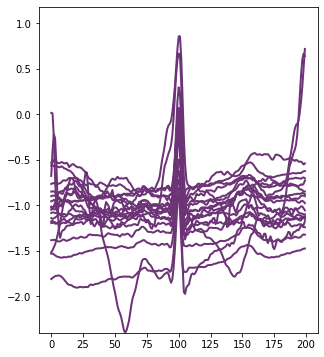

{'seq_nr': 0, 'rpeak': 1652, 'symbol': 'N'}


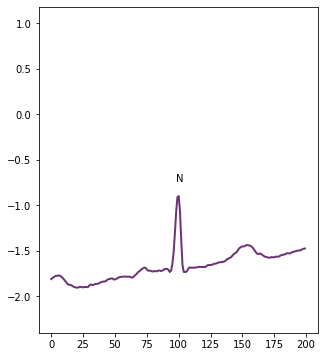

{'seq_nr': 1, 'rpeak': 1815, 'symbol': 'N'}


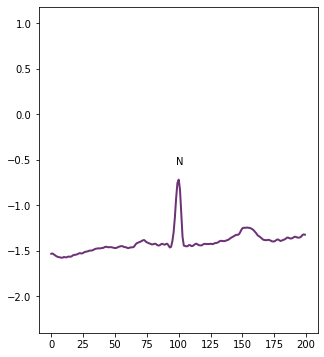

{'seq_nr': 2, 'rpeak': 1983, 'symbol': 'N'}


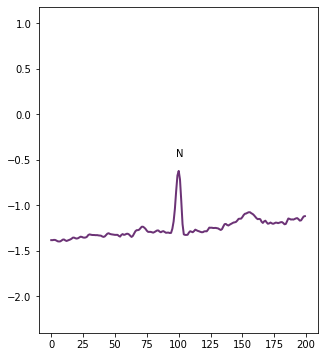


item: 10 cluster: 5 size: 10
statistika klasteryje:  ['N'] [10] 10


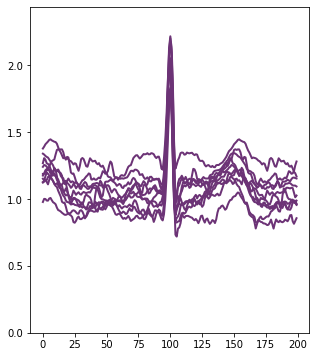

{'seq_nr': 0, 'rpeak': 51857, 'symbol': 'N'}


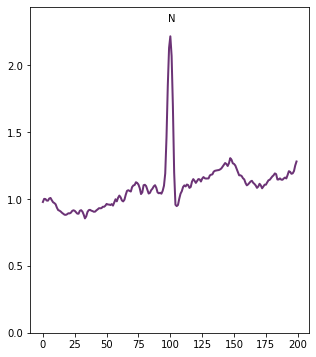

{'seq_nr': 1, 'rpeak': 52003, 'symbol': 'N'}


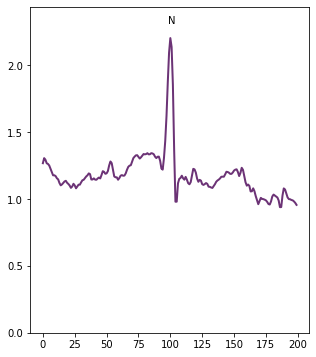

{'seq_nr': 2, 'rpeak': 52150, 'symbol': 'N'}


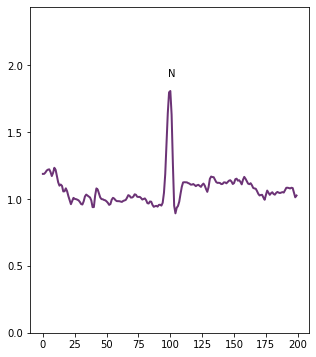


item: 11 cluster: 8 size: 4
statistika klasteryje:  ['N'] [4] 4


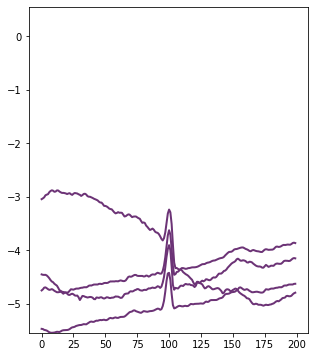

{'seq_nr': 0, 'rpeak': 615, 'symbol': 'N'}


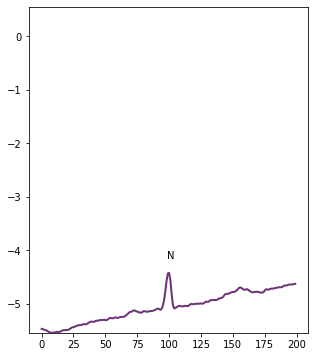

{'seq_nr': 1, 'rpeak': 768, 'symbol': 'N'}


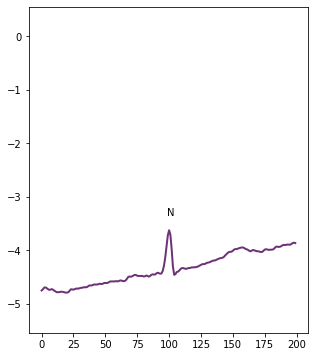

{'seq_nr': 2, 'rpeak': 49933, 'symbol': 'N'}


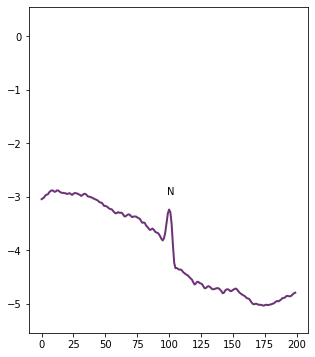


item: 12 cluster: 1 size: 4
statistika klasteryje:  ['N'] [4] 4


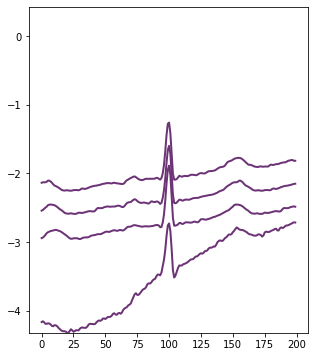

{'seq_nr': 0, 'rpeak': 1207, 'symbol': 'N'}


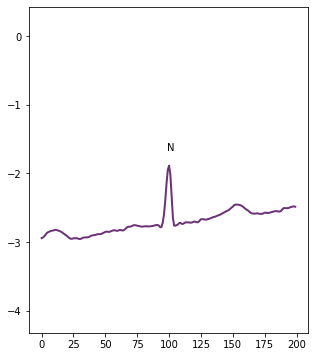

{'seq_nr': 1, 'rpeak': 1353, 'symbol': 'N'}


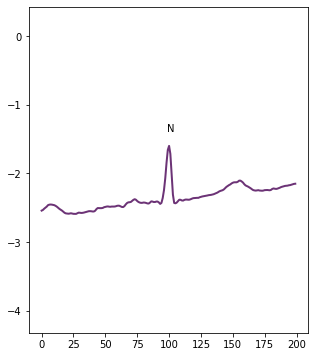

{'seq_nr': 2, 'rpeak': 1503, 'symbol': 'N'}


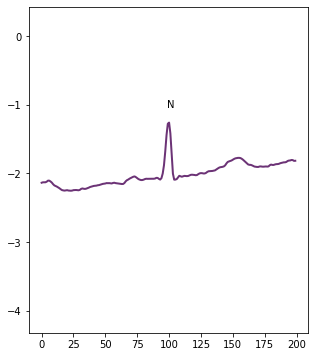


item: 13 cluster: 17 size: 3
statistika klasteryje:  ['N'] [3] 3


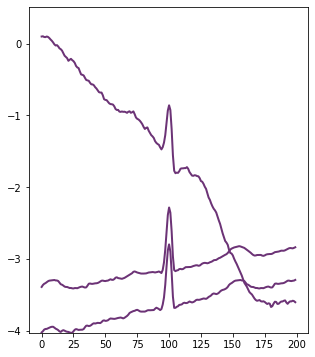

{'seq_nr': 0, 'rpeak': 917, 'symbol': 'N'}


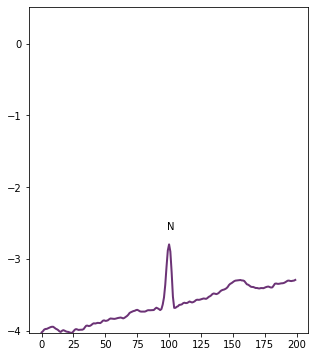

{'seq_nr': 1, 'rpeak': 1063, 'symbol': 'N'}


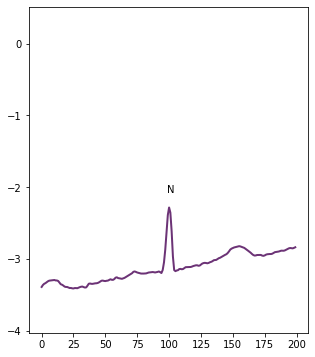

{'seq_nr': 2, 'rpeak': 49641, 'symbol': 'N'}


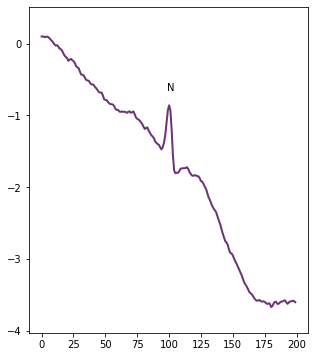


item: 14 cluster: 3 size: 2
statistika klasteryje:  ['N'] [2] 2


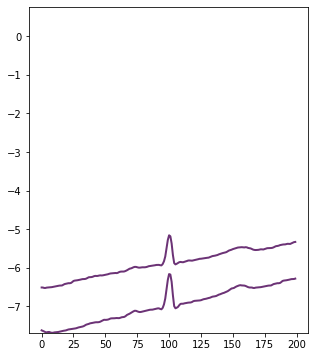

{'seq_nr': 0, 'rpeak': 291, 'symbol': 'N'}


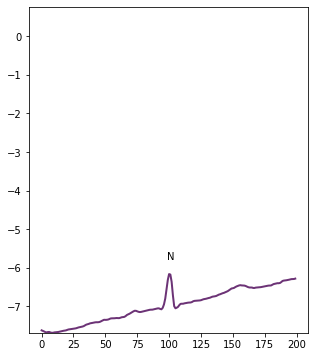

{'seq_nr': 1, 'rpeak': 455, 'symbol': 'N'}


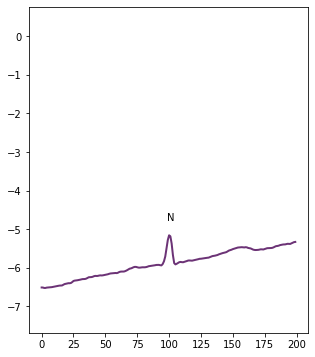


item: 15 cluster: 10 size: 1
statistika klasteryje:  ['V'] [1] 1
V: (idx, rpeak) {0: 89609}
{'seq_nr': 0, 'rpeak': 89609, 'symbol': 'V'}


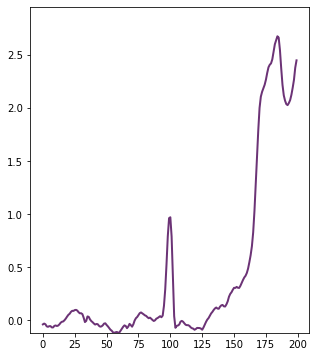


item: 16 cluster: 15 size: 1
statistika klasteryje:  ['N'] [1] 1
{'seq_nr': 0, 'rpeak': 90270, 'symbol': 'N'}


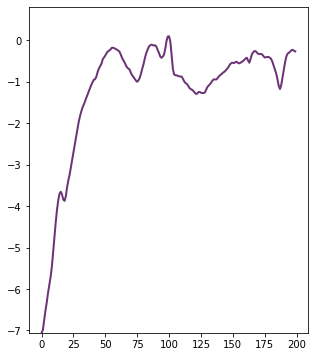


item: 17 cluster: 11 size: 1
statistika klasteryje:  ['N'] [1] 1
{'seq_nr': 0, 'rpeak': 90012, 'symbol': 'N'}


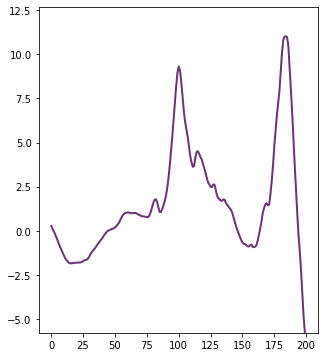


item: 18 cluster: 4 size: 1
statistika klasteryje:  ['N'] [1] 1
{'seq_nr': 0, 'rpeak': 90096, 'symbol': 'N'}


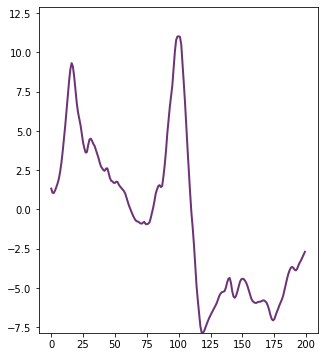


item: 19 cluster: 19 size: 1
statistika klasteryje:  ['V'] [1] 1
V: (idx, rpeak) {0: 106936}
{'seq_nr': 0, 'rpeak': 106936, 'symbol': 'V'}


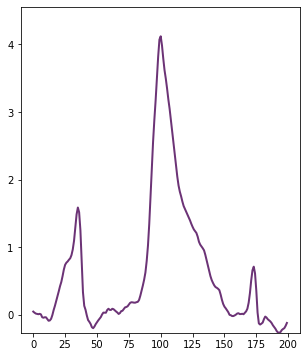


item: XX cluster: 99 size: 15
statistika: ['U'] [15] 15
U: (idx, rpeak) {0: 49788, 1: 50082, 2: 50233, 3: 50689, 4: 50981, 5: 57496, 6: 77551, 7: 78138, 8: 88315, 9: 88543, 10: 88848, 11: 88977, 12: 89717, 13: 91750, 14: 109064}


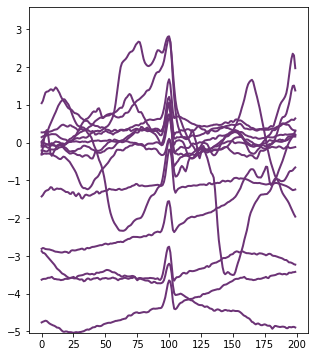

{'seq_nr': 0, 'rpeak': 49788, 'symbol': 'U'}


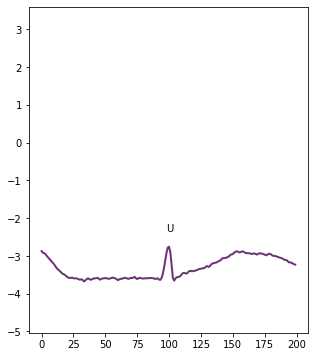

{'seq_nr': 1, 'rpeak': 50082, 'symbol': 'U'}


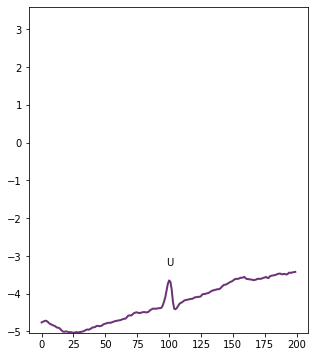

{'seq_nr': 2, 'rpeak': 50233, 'symbol': 'U'}


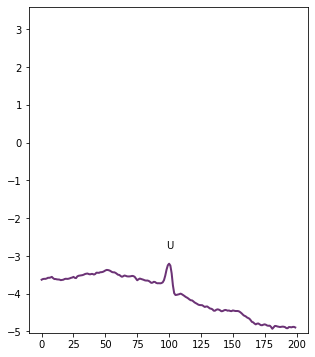

In [4]:
# Grafinis atvaizdavimas

# Išvedame įrašo atributus
userId, recId, file_name = get_recId(rec_dir, userNr, recNr)
print(f"\nSubjCode: {SubjCode} userNr: {userNr:>2} file_name: {file_name:>2} userId: {userId} recId: {recId} signal_length: {signal_length}")

# Klaidos tikrinimas
atr_symbol_be_U_n = np.array(list(df_attr_be_U['atr_symbol']))
if (not np.array_equal(atr_symbol_be_U_n, atr_symbol_be_U)):
    raise Exception("nesutampa atr_symbol_be_U")

# Bendra statistika apie pūpsnius be 'U'
(unique, counts) = np.unique(atr_symbol_be_U, return_counts=True)
total = counts.sum()
print("\nBendra statistika:")
print("Klasės be 'U': ", unique, counts, total)

# Bendra statistika apie pūpsnius su 'U'
atr_symbol_su_U = np.array(list(df_attr_su_U['atr_symbol']))
(unique, counts) = np.unique(atr_symbol_su_U, return_counts=True)
total = counts.sum()
print("Klasės su 'U' (be 1-o ir paskutinio pūpsnio):", unique, counts, total)
print()

# Sugrupuojame atributus pagal klasterius,
# surandame klasterių indeksus mažėjančia klasterių dydžio tvarka 
gr = df_attr_be_U.groupby(['cluster'])
sr_sizes = gr.size()
sr_sizes = sr_sizes.sort_values(ascending=False)
df_sizes = sr_sizes.to_frame(name='sizes').reset_index()

# čia įdedame spausdinimo ciklą per klaserius, išvesdami klasterio statistiką
for item, row in df_sizes.iterrows():
    cluster = row['cluster']
    df_gr = gr.get_group(cluster)
    atr_symbol_clust = np.array(list(df_gr['atr_symbol']))
    (unique, counts) = np.unique(atr_symbol_clust, return_counts=True)
    total = counts.sum()
    print(f'item: {item:>6}   cluster: {cluster:>6}   statistika: {unique} {counts} {total}')

# Klasteris U 
atr_symbol_su_U = np.array(list(df_attr_su_U['atr_symbol']))
(unique, counts) = np.unique(atr_symbol_su_U, return_counts=True)
total = counts.sum()
print(f'item: {"XX":>6}   cluster: {99:>6}   statistika: {unique} {counts} {total}')


# mark2

# ////////////////////////////  PARAMETRAI VAIZDAVIMUI  ////////////////////////////////////////////////////

# Maksimalus grafikų skaičius, išvedant kiekvieną grafiką klasteryje atskirai 
max_graphs = 3

# EKG pūpsnio reikšmių lango į vieną pusę plotis
w_side = 100

# Lango, kuriame vaizduojami grafikai, plotis ir aukštis
fig_width, fig_height = 5, 6

# Užduodame, kuriuos klasterius rodysime (eilės nr iš df_sizes)
start, end = 0, 20

# Užduodame, ar rodyti klasterį su U
U_flag = True

# Ciklas per užduotus klasterius
clusters_sorted = sr_sizes.index

# Ciklas per klasterius
for item in range(start,end):
    cluster = clusters_sorted[item]
    df_gr = gr.get_group(cluster)
    print('\nitem:', item, 'cluster:', cluster, 'size:', len(df_gr))

    #  Statistika apie pūpsnius klasteryje
    atr_symbol_clust = np.array(list(df_gr['atr_symbol']))
    (unique, counts) = np.unique(atr_symbol_clust, return_counts=True)
    total = counts.sum()
    print("statistika klasteryje: ", unique, counts, total)

    df_S = df_gr.loc[df_gr['atr_symbol'] == 'S', 'atr_sample']
    if (not df_S.empty):
        dict_S = df_S.to_dict()
        print('S: (idx, rpeak)', dict_S)

    df_V = df_gr.loc[df_gr['atr_symbol'] == 'V', 'atr_sample']
    if (not df_V.empty):
        dict_V = df_V.to_dict()
        print('V: (idx, rpeak)', dict_V)

    if (len(df_gr) == 1):   
        dict_attr = {'seq_nr':0, 'rpeak':df_gr['atr_sample'].values[0], 'symbol':df_gr['atr_symbol'].values[0]}
        print(dict_attr)  

    # Grafika
    min, max = get_sequences_min_max(signal, df_gr, w_side)
    show_beats_in_same_plot(signal, df_gr, w_side, min, max, fig_width, fig_height)

    if ((max_graphs != 0) and (len(df_gr) != 1)):
        show_beats(signal, df_gr, w_side, min, max, fig_width, fig_height, max_graphs= max_graphs)

# Išvedame klasterį su anotacija 'U'
if (U_flag):
    atr_symbol_su_U = np.array(list(df_attr_su_U['atr_symbol']))
    (unique, counts) = np.unique(atr_symbol_su_U, return_counts=True)
    total = counts.sum()
    print(f'\nitem: {"XX":>1} cluster: {99:>1} size: {len(atr_symbol_su_U)}') 
    print(f'statistika: {unique} {counts} {total}')

    df_U = pd.Series(df_attr_su_U['atr_sample'])
    if (not df_U.empty):
        dict_U = df_U.to_dict()
        print('U: (idx, rpeak)', dict_U)

    if (len(df_attr_su_U) == 1):   
        dict_attr = {'seq_nr':0, 'rpeak':df_attr_su_U['atr_sample'].values[0], 'symbol':df_attr_su_U['atr_symbol'].values[0]}
        print(dict_attr)
          
    min, max = get_sequences_min_max(signal, df_attr_su_U, w_side)
    show_beats_in_same_plot(signal, df_attr_su_U, w_side, min, max, fig_width, fig_height)
    
    if ((max_graphs != 0)  and (len(df_attr_su_U) != 1)):
        show_beats(signal, df_attr_su_U, w_side, min, max, fig_width, fig_height, max_graphs= max_graphs)